# SS GLM 

>The following codes are demos only. It's **NOT for production** due to system security concerns, please **DO NOT** use it directly in production.


## Train a model with sklearn 

Replicate the same experiment from sklearn [tutorial](https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims) on insurance claims using sf ss glm.

In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_tweedie_deviance,
)


def load_mtpl2(n_samples=None):
    """Fetch the French Motor Third-Party Liability Claims dataset.

    Parameters
    ----------
    n_samples: int, default=None
      number of samples to select (for faster run time). Full dataset has
      678013 samples.
    """
    
    # freMTPL2freq dataset from https://www.openml.org/d/41214
    df_freq = fetch_openml(data_id=41214, as_frame=True).data
    df_freq["IDpol"] = df_freq["IDpol"].astype(int)
    df_freq.set_index("IDpol", inplace=True)

    # freMTPL2sev dataset from https://www.openml.org/d/41215
    df_sev = fetch_openml(data_id=41215, as_frame=True).data

    # sum ClaimAmount over identical IDs
    df_sev = df_sev.groupby("IDpol").sum()

    df = df_freq.join(df_sev, how="left")
    df["ClaimAmount"].fillna(0, inplace=True)

    # unquote string fields
    for column_name in df.columns[df.dtypes.values == object]:
        df[column_name] = df[column_name].str.strip("'")
    return df.iloc[:n_samples]


def plot_obs_pred(
    df,
    feature,
    weight,
    observed,
    predicted,
    y_label=None,
    title=None,
    ax=None,
    fill_legend=False,
):
    """Plot observed and predicted - aggregated per feature level.

    Parameters
    ----------
    df : DataFrame
        input data
    feature: str
        a column name of df for the feature to be plotted
    weight : str
        column name of df with the values of weights or exposure
    observed : str
        a column name of df with the observed target
    predicted : DataFrame
        a dataframe, with the same index as df, with the predicted target
    fill_legend : bool, default=False
        whether to show fill_between legend
    """
    # aggregate observed and predicted variables by feature level
    df_ = df.loc[:, [feature, weight]].copy()
    df_["observed"] = df[observed] * df[weight]
    df_["predicted"] = predicted * df[weight]
    df_ = (
        df_.groupby([feature])[[weight, "observed", "predicted"]]
        .sum()
        .assign(observed=lambda x: x["observed"] / x[weight])
        .assign(predicted=lambda x: x["predicted"] / x[weight])
    )

    ax = df_.loc[:, ["observed", "predicted"]].plot(style=".", ax=ax)
    y_max = df_.loc[:, ["observed", "predicted"]].values.max() * 0.8
    p2 = ax.fill_between(
        df_.index,
        0,
        y_max * df_[weight] / df_[weight].values.max(),
        color="g",
        alpha=0.1,
    )
    if fill_legend:
        ax.legend([p2], ["{} distribution".format(feature)])
    ax.set(
        ylabel=y_label if y_label is not None else None,
        title=title if title is not None else "Train: Observed vs Predicted",
    )


def score_estimator(
    estimator,
    X_train,
    X_test,
    df_train,
    df_test,
    target,
    weights,
    tweedie_powers=None,
):
    """Evaluate an estimator on train and test sets with different metrics"""

    metrics = [
        ("D² explained", None),  # Use default scorer if it exists
        ("mean abs. error", mean_absolute_error),
        ("mean squared error", mean_squared_error),
    ]
    if tweedie_powers:
        metrics += [
            (
                "mean Tweedie dev p={:.4f}".format(power),
                partial(mean_tweedie_deviance, power=power),
            )
            for power in tweedie_powers
        ]

    res = []
    for subset_label, X, df in [
        ("train", X_train, df_train),
        ("test", X_test, df_test),
    ]:
        y, _weights = df[target], df[weights]
        for score_label, metric in metrics:
            if isinstance(estimator, tuple) and len(estimator) == 2:
                # Score the model consisting of the product of frequency and
                # severity models.
                est_freq, est_sev = estimator
                y_pred = est_freq.predict(X) * est_sev.predict(X)
            else:
                y_pred = estimator.predict(X)

            if metric is None:
                if not hasattr(estimator, "score"):
                    continue
                score = estimator.score(X, y, sample_weight=_weights)
            else:
                score = metric(y, y_pred, sample_weight=_weights)

            res.append({"subset": subset_label, "metric": score_label, "score": score})

    res = (
        pd.DataFrame(res)
        .set_index(["metric", "subset"])
        .score.unstack(-1)
        .round(4)
        .loc[:, ["train", "test"]]
    )
    return res

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    KBinsDiscretizer,
    OneHotEncoder,
    StandardScaler,
)

df = load_mtpl2()

# Note: filter out claims with zero amount, as the severity model
# requires strictly positive target values.
df.loc[(df["ClaimAmount"] == 0) & (df["ClaimNb"] >= 1), "ClaimNb"] = 0

# Correct for unreasonable observations (that might be data error)
# and a few exceptionally large claim amounts
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=200000)

log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log), StandardScaler()
)

column_trans = ColumnTransformer(
    [
        (
            "binned_numeric",
            KBinsDiscretizer(n_bins=10, subsample=int(2e5), random_state=0),
            ["VehAge", "DrivAge"],
        ),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
    ],
    remainder="drop",
)
X = column_trans.fit_transform(df)

# Insurances companies are interested in modeling the Pure Premium, that is
# the expected total claim amount per unit of exposure for each policyholder
# in their portfolio:
df["PurePremium"] = df["ClaimAmount"] / df["Exposure"]

# This can be indirectly approximated by a 2-step modeling: the product of the
# Frequency times the average claim amount per claim:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]
df["AvgClaimAmount"] = df["ClaimAmount"] / np.fmax(df["ClaimNb"], 1)

with pd.option_context("display.max_columns", 15):
    print(df[df.ClaimAmount > 0].head())

/tmp/ipykernel_1754454/2891303986.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["ClaimAmount"].fillna(0, inplace=True)


       ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
IDpol                                                                           
139          1      0.75    F         7       1       61          50      B12   
190          1      0.14    B        12       5       50          60      B12   
414          1      0.14    E         4       0       36          85      B12   
424          2      0.62    F        10       0       51         100      B12   
463          1      0.31    A         5       0       45          50      B12   

        VehGas  Density Region  ClaimAmount   PurePremium  Frequency  \
IDpol                                                                  
139    Regular    27000    R11       303.00    404.000000   1.333333   
190     Diesel       56    R25      1981.84  14156.000000   7.142857   
414    Regular     4792    R11      1456.55  10403.928571   7.142857   
424    Regular    27000    R11     10834.00  17474.193548   3.225806   


In [3]:
from sklearn.model_selection import train_test_split

df_train, df_test, X_train, X_test = train_test_split(df, X, random_state=0)

### Fit the GLM model (tweedie)


In [4]:
from sklearn.linear_model import TweedieRegressor

glm_pure_premium = TweedieRegressor(power=1.9, alpha=0.1, solver='newton-cholesky')
glm_pure_premium.fit(
    X_train, df_train["PurePremium"], sample_weight=df_train["Exposure"]
)

tweedie_powers = [1.5, 1.7, 1.8, 1.9, 1.99, 1.999, 1.9999]

scores_glm_pure_premium = score_estimator(
    glm_pure_premium,
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores = pd.concat(
    [scores_glm_pure_premium],
    axis=1,
    sort=True,
    keys=("TweedieRegressor"),
)
print("Evaluation of the Product Model and the Tweedie Regressor on target PurePremium")
with pd.option_context("display.expand_frame_repr", False):
    print(scores)

Evaluation of the Product Model and the Tweedie Regressor on target PurePremium
                                      T              
subset                            train          test
metric                                               
D² explained               1.640000e-02  1.370000e-02
mean Tweedie dev p=1.5000  7.640770e+01  7.640880e+01
mean Tweedie dev p=1.7000  3.682880e+01  3.692270e+01
mean Tweedie dev p=1.8000  3.037600e+01  3.045390e+01
mean Tweedie dev p=1.9000  3.382120e+01  3.387830e+01
mean Tweedie dev p=1.9900  2.015347e+02  2.015587e+02
mean Tweedie dev p=1.9990  1.914538e+03  1.914387e+03
mean Tweedie dev p=1.9999  1.904747e+04  1.904558e+04
mean abs. error            2.739865e+02  2.731249e+02
mean squared error         3.295505e+07  3.213056e+07


/tmp/ipykernel_1754454/58735475.py:21: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  scores = pd.concat(


In [5]:
n_iter = glm_pure_premium.n_iter_

### Fit the SS GLM model (tweedie)


In [6]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))


# In case you have a running secretflow runtime already.
try:
    sf.shutdown()
except:
    pass  # Already shutdown or not initialized


sf.init(['alice', 'bob'], address='local')

alice, bob = sf.PYU('alice'), sf.PYU('bob')
spu = sf.SPU(
    sf.utils.testing.cluster_def(
        ['alice', 'bob'],
        {"protocol": "REF2K", "field": "FM128", "fxp_fraction_bits": 40},
    ),
)

The version of SecretFlow: 1.12.0b0


/dssg/home/acct-ioozys/ioozys-user2/.conda/envs/secretflow/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/dssg/home/acct-ioozys/ioozys-user2/.conda/envs/secretflow/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2025-06-26 00:51:00,307	INFO worker.py:1841 -- Started a local Ray instance.


(raylet) Warning: The remote function secretflow.device.device.pyu.<lambda>@3323407125.py:28@PYU(alice) is very large (11 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(SPURuntime pid=1755135) 2025-06-26 00:51:03.523 [warning] [openssl_factory.cc:OpensslDrbg:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce
(SPURuntime pid=1755135) 2025-06-26 00:51:03.525 [warning] [openssl_factory.cc:OpensslDrbg:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce


(pyu_fn pid=1755138) 2025-06-26 00:51:03,906,906 INFO [xla_bridge.py:backends:863] Unable to initialize backend 'cuda': 
(pyu_fn pid=1755138) 2025-06-26 00:51:03,907,907 INFO [xla_bridge.py:backends:863] Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
(pyu_fn pid=1755138) 2025-06-26 00:51:03,907,907 INFO [xla_bridge.py:backends:863] Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


(pyu_fn pid=1755150) [2025-06-26 00:51:04.035] [info] [thread_pool.cc:30] Create a fixed thread pool with size 63
(raylet) Warning: The remote function secretflow.device.device.pyu.<lambda>@3956590721.py:7@PYU(alice) is very large (11 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


In [7]:
from secretflow.data import FedNdarray, PartitionWay
import ray

x, y = X_train, df_train["PurePremium"]
w = df_train["Exposure"]

def x_to_vdata(x):
    
    # convert type to numpy.ndarray
    x_dense = np.asarray(x.todense())
    
    # put date into Ray Object store
    x_ref = ray.put(x_dense)

    v_data = FedNdarray(
        partitions={
            alice: alice(lambda x_ref=x_ref: np.asarray(ray.get(x_ref)[:, :15]))(),
            bob: bob(lambda x_ref=x_ref: np.asarray(ray.get(x_ref)[:, 15:]))(),
        },
        partition_way=PartitionWay.VERTICAL,
    )
    return v_data


v_data = x_to_vdata(x)

label_data = FedNdarray(
    partitions={alice: alice(lambda: y.values)()},
    partition_way=PartitionWay.VERTICAL,
)

sample_weight = FedNdarray(
    partitions={alice: alice(lambda: w.values)()},
    partition_way=PartitionWay.VERTICAL,
)

In [8]:
from secretflow.device.driver import reveal
from secretflow.ml.linear.ss_glm.core import get_dist

dist = 'Tweedie'
ss_glm_power = 1.9


class DirectRevealModel:
    def __init__(self, model) -> None:
        self.model = model

    def predict(self, X):
        vdata = x_to_vdata(X)
        y = self.model.predict(vdata)
        return reveal(y).reshape((-1,))

    def score(self, X, y, sample_weight=None):
        y = y.values
        y_pred = self.predict(X)

        constant = np.mean(y)
        if sample_weight is not None:
            constant *= sample_weight.shape[0] / np.sum(sample_weight)

        # Missing factor of 2 in deviance cancels out.
        deviance = get_dist(dist, 1, ss_glm_power).deviance(y_pred, y, None)
        deviance_null = get_dist(dist, 1, ss_glm_power).deviance(
            np.average(y, weights=sample_weight) + np.zeros(y.shape), y, None
        )
        return 1 - (deviance + constant) / (deviance_null + constant)

In [9]:
import time
from secretflow.ml.linear.ss_glm import SSGLM

model = SSGLM(spu)

ss_glm_power = 1.9
start = time.time()
model.fit_irls(
    v_data,
    label_data,
    None,
    sample_weight,
    2,
    'Log',
    'Tweedie',
    ss_glm_power,
    l2_lambda=0.1,
    infeed_batch_size_limit=8000000,
    fraction_of_validation_set=0.2,
    stopping_rounds=2,
    stopping_metric='deviance',
    stopping_tolerance=0.001,
)

wrapped_model = DirectRevealModel(model)

In [10]:
reveal(model.spu_w)

array([[-9.8047949e-02],
       [ 1.2626581e-01],
       [ 3.2944429e-01],
       [-1.1954460e-01],
       [-4.8946202e-02],
       [ 1.4846238e-01],
       [-6.7145325e-02],
       [-6.2920310e-02],
       [-9.6078180e-02],
       [-4.0368196e-01],
       [ 2.0416974e-01],
       [-6.7801440e-01],
       [-3.7561753e-01],
       [-9.6824460e-02],
       [-1.1970766e-02],
       [-5.8242079e-02],
       [ 2.4121864e-01],
       [ 1.1442662e-03],
       [ 1.4785905e-01],
       [ 2.5173706e-01],
       [-3.2257536e-01],
       [ 5.2883631e-01],
       [ 4.7851691e-01],
       [-2.8733122e-01],
       [ 2.6545596e-01],
       [-3.9846620e-01],
       [ 4.3898139e-02],
       [ 1.0642537e-02],
       [-6.0040105e-02],
       [-1.0884118e-01],
       [-5.5215538e-01],
       [-1.8020713e-01],
       [-4.0898207e-01],
       [-4.7065523e-02],
       [-1.6955884e-01],
       [-4.3574652e-01],
       [ 1.8392390e-01],
       [ 3.2649565e-01],
       [ 3.1254733e-01],
       [ 1.9056559e-01],


In [11]:
tweedie_powers = [1.5, 1.7, 1.8, 1.9, 1.99, 1.999, 1.9999]

scores_ss_glm_pure_premium = score_estimator(
    wrapped_model,
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores = pd.concat(
    [scores_glm_pure_premium, scores_ss_glm_pure_premium],
    axis=1,
    sort=True,
    keys=("TweedieRegressor", "SSGLMRegressor"),
)
print("Evaluation of the Tweedie Regressor and SS GLM on target PurePremium")
with pd.option_context("display.expand_frame_repr", False):
    print(scores)

[2025-06-26 00:51:17.997] [info] [thread_pool.cc:30] Create a fixed thread pool with size 63
Evaluation of the Tweedie Regressor and SS GLM on target PurePremium
                          TweedieRegressor                 SSGLMRegressor                  
subset                               train          test            train              test
metric                                                                                     
D² explained                  1.640000e-02  1.370000e-02      -0.07047176      -0.039444804
mean Tweedie dev p=1.5000     7.640770e+01  7.640880e+01        83.042356         85.102671
mean Tweedie dev p=1.7000     3.682880e+01  3.692270e+01        39.211783         40.151112
mean Tweedie dev p=1.8000     3.037600e+01  3.045390e+01        31.882016         32.509283
mean Tweedie dev p=1.9000     3.382120e+01  3.387830e+01         34.79712         35.212837
mean Tweedie dev p=1.9900     2.015347e+02  2.015587e+02       202.206189        202.475171
mean Tweed

In [12]:
res = []
for subset_label, x, df in [
    ("train", X_train, df_train),
    ("test", X_test, df_test),
]:
    exposure = df["Exposure"].values
    res.append(
        {
            "subset": subset_label,
            "observed": df["ClaimAmount"].values.sum(),
            "predicted, tweedie, power=%.2f"
            % glm_pure_premium.power: np.sum(exposure * glm_pure_premium.predict(x)),
            "predicted, ss glm, power=%.2f"
            % ss_glm_power: np.sum(exposure * wrapped_model.predict(x)),
        }
    )

print(pd.DataFrame(res).set_index("subset").T)

subset                                 train          test
observed                        3.917618e+07  1.299546e+07
predicted, tweedie, power=1.90  3.951751e+07  1.325198e+07
predicted, ss glm, power=1.90   7.075773e+07  2.906789e+07


[]

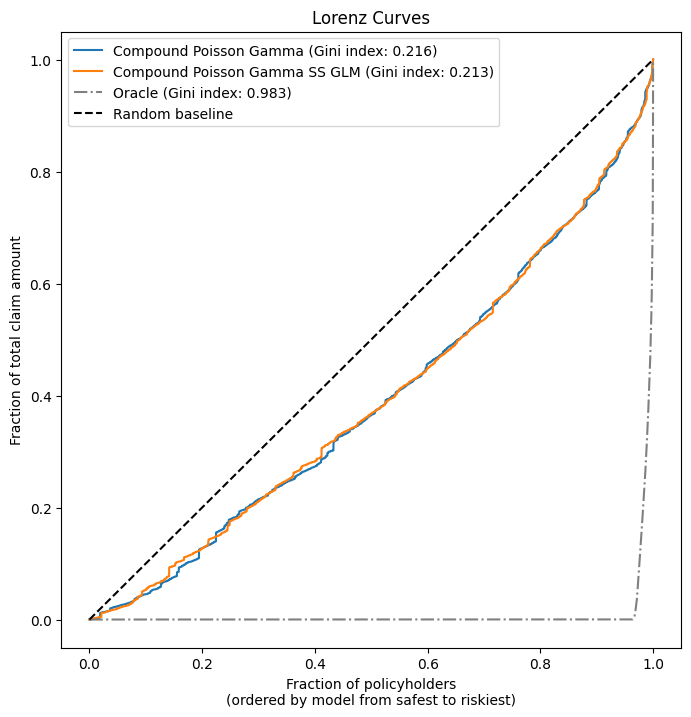

In [13]:
from sklearn.metrics import auc


def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount


fig, ax = plt.subplots(figsize=(8, 8))

y_pred_total_ss_glm = wrapped_model.predict(X_test).reshape((-1,))
y_pred_total = glm_pure_premium.predict(X_test)

for label, y_pred in [
    ("Compound Poisson Gamma", y_pred_total),
    ("Compound Poisson Gamma SS GLM", y_pred_total_ss_glm),
]:
    ordered_samples, cum_claims = lorenz_curve(
        df_test["PurePremium"], y_pred, df_test["Exposure"]
    )
    gini = 1 - 2 * auc(ordered_samples, cum_claims)
    label += " (Gini index: {:.3f})".format(gini)
    ax.plot(ordered_samples, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
ordered_samples, cum_claims = lorenz_curve(
    df_test["PurePremium"], df_test["PurePremium"], df_test["Exposure"]
)
gini = 1 - 2 * auc(ordered_samples, cum_claims)
label = "Oracle (Gini index: {:.3f})".format(gini)
ax.plot(ordered_samples, cum_claims, linestyle="-.", color="gray", label=label)

# Random baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz Curves",
    xlabel="Fraction of policyholders\n(ordered by model from safest to riskiest)",
    ylabel="Fraction of total claim amount",
)
ax.legend(loc="upper left")
plt.plot()

# SS GLM vs stats model package (offset)

Statsmodel is another cleartext package with glm functionality.

Next we compare ss glm with stats model when using the offset option. The overall steps are very similar, but there is a slight difference in how the offset is handled.

In [14]:
import pandas as pd

from functools import partial
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_tweedie_deviance,
)


def score_estimator(
    estimator,
    X_train,
    X_test,
    df_train,
    df_test,
    target,
    weights=None,
    tweedie_powers=None,
):
    """Evaluate an estimator on train and test sets with different metrics"""

    metrics = [
        ("D² explained", None),  # Use default scorer if it exists
        ("mean abs. error", mean_absolute_error),
        ("mean squared error", mean_squared_error),
    ]
    if tweedie_powers:
        metrics += [
            (
                "mean Tweedie dev p={:.4f}".format(power),
                partial(mean_tweedie_deviance, power=power),
            )
            for power in tweedie_powers
        ]

    res = []
    for subset_label, X, df in [
        ("train", X_train, df_train),
        ("test", X_test, df_test),
    ]:
        y = df[target]
        if weights is not None:
            _weights = df[weights]
        else:
            _weights = None
        for score_label, metric in metrics:
            if isinstance(estimator, tuple) and len(estimator) == 2:
                # Score the model consisting of the product of frequency and
                # severity models.
                est_freq, est_sev = estimator
                y_pred = est_freq.predict(X) * est_sev.predict(X)
            else:
                y_pred = estimator.predict(X)

            if metric is None:
                if not hasattr(estimator, "score"):
                    continue
                score = estimator.score(X, y, sample_weight=_weights)
            else:
                score = metric(y, y_pred, sample_weight=_weights)

            res.append({"subset": subset_label, "metric": score_label, "score": score})

    res = (
        pd.DataFrame(res)
        .set_index(["metric", "subset"])
        .score.unstack(-1)
        .round(4)
        .loc[:, ["train", "test"]]
    )
    return res

## Using the statsmodels package

In [15]:
from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm

sm_glm = GLM(
    endog=df_train["ClaimAmount"].values,
    exog=sm.add_constant(X_train.todense()),
    offset=df_train["Exposure"].values,
    family=sm.families.Tweedie(),
    var_power=1.9,
)
results = sm_glm.fit(method='IRLS')

/dssg/home/acct-ioozys/ioozys-user2/.conda/envs/secretflow/lib/python3.10/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['var_power']
  warnings.warn(msg, ValueWarning)
/dssg/home/acct-ioozys/ioozys-user2/.conda/envs/secretflow/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1582: RuntimeWarning: divide by zero encountered in log
  endog * np.log(endog / mu) + (mu - endog))
/dssg/home/acct-ioozys/ioozys-user2/.conda/envs/secretflow/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1582: RuntimeWarning: invalid value encountered in multiply
  endog * np.log(endog / mu) + (mu - endog))


In [16]:
results.summary()

/dssg/home/acct-ioozys/ioozys-user2/.conda/envs/secretflow/lib/python3.10/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['var_power']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               508509
Model:                            GLM   Df Residuals:                   508440
Model Family:                 Tweedie   Df Model:                           68
Link Function:                    Log   Scale:                          31356.
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 26 Jun 2025   Deviance:                   3.3200e+08
Time:                        00:52:07   Pearson chi2:                 1.59e+10
No. Iterations:                    11   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9706      0.074     13.120      0.000       0.826       1.116
x1            -0.1729      0.130     -1.326      0.185      -0.429       0.083
x2             0.2374      0.091      2.616      0.009       0.060       0.415
x3             0.3050      0.091      3.367      0.001       0.127       0.483
x4             0.1390      0.102      1.366      0.172      -0.060       0.338
x5             0.1656      0.077      2.145      0.032       0.014       0.317
x6             0.2642      0.078      3.395      0.001       0.112       0.417
x7             0.0887      0.085      1.042      0.297      -0.078       0.256
x8             0.0240      0.085      0.282      0.778      -0.143       0.191
x9             0.0872      0.078      1.117      0.264      -0.066       0.240
x10           -0.1676      0.091     -1.845      0.065      -0.346       0.010
x11            0.1393      0.085      1.644      0.100      -0.027       0.305
x12           -0.2945      0.102     -2.900      0.004      -0.494      -0.095
x13           -0.1101      0.093     -1.185      0.236      -0.292       0.072
x14            0.0254      0.089      0.284      0.777      -0.150       0.201
x15            0.0878      0.091      0.966      0.334      -0.090       0.266
x16            0.1123      0.084      1.337      0.181      -0.052       0.277
x17            0.2764      0.086      3.231      0.001       0.109       0.444
x18            0.1865      0.094      1.981      0.048       0.002       0.371
x19            0.1555      0.088      1.763      0.078      -0.017       0.329
x20            0.3920      0.080      4.924      0.000       0.236       0.548
x21            0.0367      0.076      0.481      0.631      -0.113       0.186
x22            0.2159      0.157      1.374      0.169      -0.092       0.524
x23            0.3589      0.166      2.165      0.030       0.034       0.684
x24           -0.1970      0.092     -2.137      0.033      -0.378      -0.016
x25            0.1552      0.187      0.832      0.405      -0.210       0.521
x26           -0.1316      0.388     -0.340      0.734      -0.891       0.628
x27            0.1657      0.074      2.236      0.025       0.020       0.311
x28            0.2124      0.099      2.148      0.032       0.019       0.406
x29            0.1688      0.136      1.242      0.214      -0.097       0.435
x30            0.1022      0.123      0.833      0.405      -0.138       0.343
x31           -0.1167      0.145     -0.807      0.420      -0.400       0.167
x32           -0.0405      0.104     -0.391      0.696      -0.244       0.163
x33           -0.1595      0.103     -1.544      0.123      -0.362       0.043
x34            0.0708      0.098      0.724      0.469      -0.121       0.262
x35            0.0521      0.095      0.550      0.583      -0.134       0.238
x3

In [20]:
from secretflow.device.driver import reveal
from secretflow.ml.linear.ss_glm.core import get_dist
from secretflow.data import FedNdarray, PartitionWay

dist = 'Tweedie'
ss_glm_power = 1.9


def x_to_vdata(x):
    
    # convert type to numpy.ndarray
    x_dense = np.asarray(x.todense())
    
    # put date into Ray Object store
    x_ref = ray.put(x_dense)

    v_data = FedNdarray(
        partitions={
            alice: alice(lambda x_ref=x_ref: np.asarray(ray.get(x_ref)[:, :15]))(),
            bob: bob(lambda x_ref=x_ref: np.asarray(ray.get(x_ref)[:, 15:]))(),
        },
        partition_way=PartitionWay.VERTICAL,
    )
    return v_data


class WrapModel:
    def __init__(self, model, fed=True) -> None:
        self.model = model
        self.fed = fed

    def predict(self, X):
        if self.fed:
            vdata = x_to_vdata(X)
            y = self.model.predict(vdata)
            return reveal(y).reshape((-1,))
        else:
            y = self.model.predict(sm.add_constant(X.todense()))
            return y.reshape((-1,))

    def score(self, X, y, sample_weight=None):
        y = y.values
        y_pred = self.predict(X)

        constant = np.mean(y)
        if sample_weight is not None:
            constant *= sample_weight.shape[0] / np.sum(sample_weight)

        # Missing factor of 2 in deviance cancels out.
        deviance = get_dist(dist, 1, ss_glm_power).deviance(y_pred, y, None)
        deviance_null = get_dist(dist, 1, ss_glm_power).deviance(
            np.average(y, weights=sample_weight) + np.zeros(y.shape), y, None
        )
        return 1 - (deviance + constant) / (deviance_null + constant)

In [21]:
wrapped_sm_model = WrapModel(results, False)

In [22]:
x, y = X_train, df_train["ClaimAmount"]
o = df_train["Exposure"]

v_data = x_to_vdata(x)

label_data = FedNdarray(
    partitions={alice: alice(lambda: y.values)()},
    partition_way=PartitionWay.VERTICAL,
)

offset = FedNdarray(
    partitions={alice: alice(lambda: o.values)()},
    partition_way=PartitionWay.VERTICAL,
)

In [23]:
import time
from secretflow.ml.linear.ss_glm import SSGLM

model = SSGLM(spu)

ss_glm_power = 1.9
start = time.time()
model.fit_irls(
    v_data,
    label_data,
    offset,
    None,
    11,
    'Log',
    'Tweedie',
    ss_glm_power,
    l2_lambda=0.1,
    infeed_batch_size_limit=8000000,
    fraction_of_validation_set=0.2,
    stopping_rounds=2,
    stopping_metric='deviance',
    stopping_tolerance=0.001,
)

wrapped_model = WrapModel(model, True)

In [24]:
tweedie_powers = [1.5, 1.7, 1.8, 1.9, 1.99, 1.999, 1.9999]

scores_ss_glm_pure_premium = score_estimator(
    wrapped_model,
    X_train,
    X_test,
    df_train,
    df_test,
    target="ClaimAmount",
    weights=None,
    tweedie_powers=tweedie_powers,
)

scores = pd.concat(
    [scores_glm_pure_premium, scores_ss_glm_pure_premium],
    axis=1,
    sort=True,
    keys=("TweedieRegressor", "SSGLMRegressor"),
)
print("Evaluation of the Tweedie Regressor and SS GLM on target PurePremium")
with pd.option_context("display.expand_frame_repr", False):
    print(scores)

Evaluation of the Tweedie Regressor and SS GLM on target PurePremium
                          TweedieRegressor                 SSGLMRegressor                
subset                               train          test            train            test
metric                                                                                   
D² explained                  1.640000e-02  1.370000e-02    -0.0071445704    -0.016812682
mean Tweedie dev p=1.5000     7.640770e+01  7.640880e+01        64.541773       66.436612
mean Tweedie dev p=1.7000     3.682880e+01  3.692270e+01        33.197171       33.926592
mean Tweedie dev p=1.8000     3.037600e+01  3.045390e+01        28.425654        28.88984
mean Tweedie dev p=1.9000     3.382120e+01  3.387830e+01        32.907691        33.20425
mean Tweedie dev p=1.9900     2.015347e+02  2.015587e+02       203.149885        203.3466
mean Tweedie dev p=1.9990     1.914538e+03  1.914387e+03      1936.674482      1936.84957
mean Tweedie dev p=1.9999     1

In [25]:
res = []
for subset_label, x, df in [
    ("train", X_train, df_train),
    ("test", X_test, df_test),
]:
    exposure = df["Exposure"].values
    res.append(
        {
            "subset": subset_label,
            "observed": df["ClaimAmount"].values.sum(),
            "predicted, tweedie, power=%.2f"
            % 1.9: np.sum(exposure * wrapped_sm_model.predict(x)),
            "predicted, ss glm, power=%.2f"
            % ss_glm_power: np.sum(exposure * wrapped_model.predict(x)),
        }
    )

print(pd.DataFrame(res).set_index("subset").T)

subset                                 train          test
observed                        3.917618e+07  1.299546e+07
predicted, tweedie, power=1.90  1.125080e+07  3.776321e+06
predicted, ss glm, power=1.90   7.389793e+07  2.713166e+07


[]

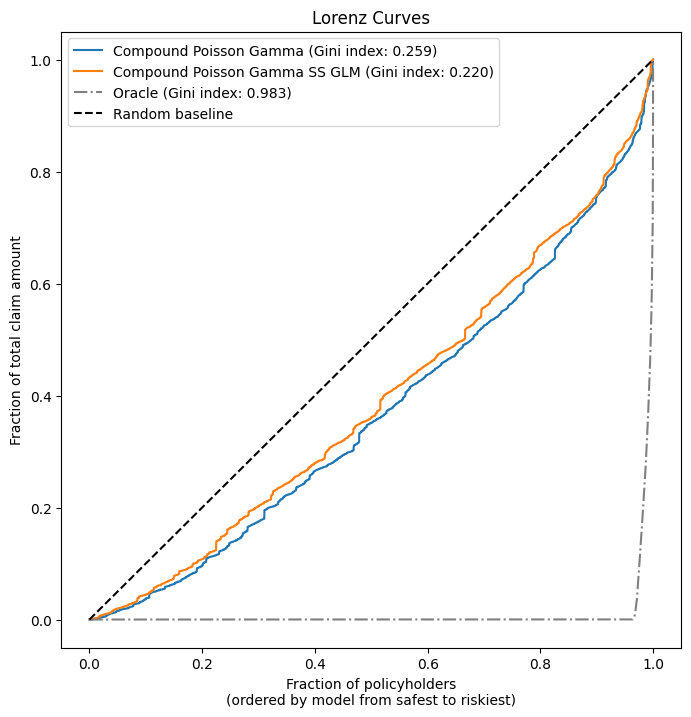

In [26]:
from sklearn.metrics import auc


def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount


fig, ax = plt.subplots(figsize=(8, 8))

y_pred_total_ss_glm = wrapped_model.predict(X_test).reshape((-1,))
y_pred_total = wrapped_sm_model.predict(X_test)

for label, y_pred in [
    ("Compound Poisson Gamma", y_pred_total),
    ("Compound Poisson Gamma SS GLM", y_pred_total_ss_glm),
]:
    ordered_samples, cum_claims = lorenz_curve(
        df_test["PurePremium"], y_pred, df_test["Exposure"]
    )
    gini = 1 - 2 * auc(ordered_samples, cum_claims)
    label += " (Gini index: {:.3f})".format(gini)
    ax.plot(ordered_samples, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
ordered_samples, cum_claims = lorenz_curve(
    df_test["PurePremium"], df_test["PurePremium"], df_test["Exposure"]
)
gini = 1 - 2 * auc(ordered_samples, cum_claims)
label = "Oracle (Gini index: {:.3f})".format(gini)
ax.plot(ordered_samples, cum_claims, linestyle="-.", color="gray", label=label)

# Random baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz Curves",
    xlabel="Fraction of policyholders\n(ordered by model from safest to riskiest)",
    ylabel="Fraction of total claim amount",
)
ax.legend(loc="upper left")
plt.plot()